# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 21.82 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (26434/26434), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical scale; actual layers scaled below to match 0.5/0.25


backbone:
  - [-1, 1, TorchVision, [768, mobilenet_v3_small, DEFAULT, True, 2, True]]  # 0

head:
  # Extract features from MobileNetV3 Small
  - [0, 1, Index, [24, 3]]           # 1: P3 raw (stride 8)
  - [1, 1, ECA, [24]]                # 2: 

  - [0, 1, Index, [48, 9]]           # 3: P4 raw (stride 16)
  - [3, 1, ECA, [48]]                # 4: 

  - [0, 1, Index, [576, 13]]         # 5: P5 raw (stride 32)
  - [5, 1, ECA, [576]]               # 6: 

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]] # 13
  - [[13, 7], 1, Concat, [1]]                  # 14
  - [-1, 1, C3k2, [64, False]]                 # 15

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                  # 16
  - [[16, 12], 1, Concat, [1]]                 # 17
  - [-1, 1, C3k2, [128, False]]                # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                 # 19
  - [[19, 9], 1, Concat, [1]]                  # 20
  - [-1, 1, C3k2, [256, True]]                 # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]            # 22



  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 16, 320, 320])
# 2 torch.Size([1, 16, 160, 160])
# 3 torch.Size([1, 24, 80, 80])
# 4 torch.Size([1, 24, 80, 80])
# 5 torch.Size([1, 40, 40, 40])
# 6 torch.Size([1, 40, 40, 40])
# 7 torch.Size([1, 40, 40, 40])
# 8 torch.Size([1, 48, 40, 40])
# 9 torch.Size([1, 48, 40, 40])
# 10 torch.Size([1, 96, 20, 20])
# 11 torch.Size([1, 96, 20, 20])
# 12 torch.Size([1, 96, 20, 20])
# 13 torch.Size([1, 576, 20, 20])
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 181MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 86.0MB/s]
E0000 00:00:1744368931.186611      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744368931.236906      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    927008  ultralytics.nn.modules.block.TorchVision     ['mobilenet_v3_small', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [3]                           
  2                   1  1         3  ultralytics.nn.modules.conv.ECA              [24]                          
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [9]                           
  4                   3  1         3  ultralytics.nn.modules.conv.ECA              [48]                          
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [13]                          
  6                   5  1         3  ultralytics.nn.modules.conv.ECA              [576]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 242MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:03<00:00, 135.05it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 115.36it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 78 weight(decay=0.0), 106 weight(decay=0.0005), 102 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.38G       3.42      101.1      2.934         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.71G      4.447      28.15      2.776         52        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

                   all        200       1017   0.000334     0.0147   0.000169   4.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.71G      3.942      5.418      1.728         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


                   all        200       1017     0.0882     0.0482     0.0135    0.00234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.71G      3.649      3.907      1.476         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017      0.199      0.137     0.0644     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.71G      3.469      3.401      1.386         50        640: 100%|██████████| 32/32 [00:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200       1017      0.169      0.125     0.0504    0.00924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.71G      3.458      3.125      1.318         30        640: 100%|██████████| 32/32 [00:10<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all        200       1017      0.266      0.203      0.119     0.0259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.71G      3.288      2.804      1.316         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


                   all        200       1017      0.277      0.206      0.122     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.71G      3.212      2.534      1.241         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        200       1017      0.351      0.237      0.151     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.71G      3.321      2.553      1.294         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017       0.21      0.221     0.0906     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.71G      3.192      2.328       1.26         48        640: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017       0.37      0.251      0.161     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.72G      3.141      2.198      1.202         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]

                   all        200       1017      0.349      0.272      0.188     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.72G      3.031      2.176      1.219         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.338      0.275      0.173     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.72G      3.078      2.123      1.251         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.47it/s]

                   all        200       1017      0.361      0.278      0.192     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.72G       2.99      1.989      1.164         23        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all        200       1017      0.347      0.277      0.185     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.72G      2.989        1.9      1.174         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.371      0.304      0.203     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.72G      2.936      1.871      1.169         46        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017      0.442       0.32      0.245     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.72G      2.922      1.798      1.152         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017       0.43      0.292      0.228      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.72G      3.072      1.822      1.227         33        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

                   all        200       1017      0.392      0.324      0.226     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.72G      2.937      1.768      1.191         49        640: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        200       1017      0.449       0.34      0.268     0.0659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.72G      2.879        1.7      1.149         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        200       1017      0.445      0.337      0.246     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.72G      2.842       1.66      1.196         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        200       1017      0.455      0.324      0.254     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.72G      2.845      1.614      1.156         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.466      0.342      0.274     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.72G      2.884       1.62       1.13         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.411      0.295      0.209     0.0494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.72G       2.89      1.616      1.146         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

                   all        200       1017      0.412      0.324      0.247     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.72G      2.888        1.6      1.148         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1017      0.489      0.343      0.306     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.72G      2.783      1.515      1.163         26        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.485      0.356      0.302     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.72G      2.824      1.504      1.113         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.501      0.367      0.319     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.72G      2.773       1.47      1.133         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.497      0.366      0.333     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.72G      2.782      1.478      1.116         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200       1017      0.485      0.352      0.293     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.72G      2.747      1.441      1.098         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200       1017      0.469       0.38      0.307     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.72G       2.74      1.441      1.172         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all        200       1017      0.443      0.371      0.301     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.72G      2.691      1.368      1.118         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017       0.52      0.372      0.338     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.72G      2.787      1.452      1.147         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        200       1017      0.468      0.369      0.304     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.72G      2.783      1.447       1.12         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.456      0.356      0.272     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.72G      2.835      1.439      1.146         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.467      0.371      0.322     0.0915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.72G      2.803      1.417      1.089         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


                   all        200       1017      0.475      0.401      0.335     0.0904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.72G      2.715       1.41      1.094         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all        200       1017      0.469      0.391      0.328     0.0884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.72G      2.722      1.358      1.101         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.502      0.409      0.337     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.72G      2.664      1.299      1.086         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017      0.493      0.417      0.349     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.72G      2.641      1.342      1.129         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.537      0.418      0.367     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.72G      2.635      1.312      1.085         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.528      0.419      0.363      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.72G      2.572      1.284      1.128         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.565      0.416      0.395      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.72G      2.678      1.303      1.071         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1017      0.487      0.382      0.329     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.72G      2.644      1.323      1.142         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.492      0.389      0.347     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.72G      2.587      1.287      1.053         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


                   all        200       1017      0.567      0.407       0.38      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.72G      2.555      1.262      1.073         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200       1017       0.54      0.409      0.362      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.72G      2.577       1.26      1.074         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.522      0.392      0.342     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.72G      2.703      1.269      1.063         40        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.517      0.399      0.362     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.72G       2.58       1.26      1.076         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200       1017      0.541      0.416      0.388      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.72G      2.596      1.259      1.074         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200       1017      0.548      0.424      0.391      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.72G      2.546      1.207      1.059         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200       1017      0.573      0.417      0.391      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.72G      2.579      1.226      1.069         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.518      0.394      0.353     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.72G      2.614      1.235      1.056         57        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.578      0.436      0.405      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.72G      2.519      1.221       1.09         33        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017       0.58       0.43        0.4      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.72G      2.486      1.215      1.116         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.564      0.395      0.371     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.72G      2.578      1.211      1.062         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        200       1017      0.566      0.426        0.4      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.72G      2.526      1.241      1.049         11        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.564      0.432      0.387      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.72G      2.566      1.208      1.083         36        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        200       1017      0.524      0.405      0.342     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.72G      2.443      1.186      1.072         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200       1017      0.535      0.389      0.364      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.72G      2.494      1.185      1.082         51        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.553      0.435      0.407       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.72G      2.531      1.213       1.04         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.543      0.428      0.396      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.72G      2.377      1.161      1.069         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.539      0.393      0.369      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.72G      2.516      1.212      1.039         45        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017      0.558      0.405      0.396      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.72G      2.457      1.161      1.054         27        640: 100%|██████████| 32/32 [00:10<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.549      0.408      0.367      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.72G      2.417      1.153      1.051         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        200       1017      0.602      0.422      0.381      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.72G       2.47      1.137       1.04         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017       0.62      0.438      0.416      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.72G      2.455      1.164      1.037         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.514      0.424      0.374      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.72G      2.455       1.14      1.055         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.608       0.43      0.403      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.72G      2.466      1.174      1.051         13        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        200       1017      0.568      0.416      0.355     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.72G      2.523        1.2      1.037         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        200       1017      0.609      0.431      0.407       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.72G      2.468      1.182      1.045         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.604      0.441      0.424      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.72G      2.395      1.077      1.062         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        200       1017      0.592      0.458       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.72G      2.447      1.139      1.036         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.584      0.425        0.4      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.72G       2.37      1.102      1.063         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.583      0.421      0.403       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.72G        2.4      1.096      1.034         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]

                   all        200       1017      0.569      0.417      0.396      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.72G      2.374      1.118      1.047         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        200       1017      0.569      0.417      0.394      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.72G      2.366      1.106      1.035         19        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.618      0.435      0.425      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.72G      2.351      1.092      1.083         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


                   all        200       1017      0.591      0.411      0.399      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.72G       2.42      1.127      1.049         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.599      0.424      0.416       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.72G       2.45      1.128      1.027         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200       1017      0.619      0.453      0.443      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.72G      2.317      1.076      1.056         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.588       0.43      0.417       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.72G      2.318      1.093      1.024         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        200       1017      0.634      0.419      0.409      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.72G      2.395      1.146      1.019         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.581      0.388       0.37      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.72G      2.411      1.104      1.041         48        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.573      0.439      0.414      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.72G      2.383      1.137      1.038         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017       0.58      0.409      0.391      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.72G       2.35      1.091      1.032         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


                   all        200       1017      0.578      0.422      0.398      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.72G      2.291       1.08      1.018         41        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.592      0.431      0.424      0.132
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 72, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



87 epochs completed in 0.365 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.9MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.9MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 206 layers, 2,299,564 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


                   all        200       1017      0.595      0.458      0.443      0.142


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d172d39eb50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
!zip -r yolo11_mobilenet.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/val_batch2_pred.jpg (deflated 14%)
  adding: kaggle/working/model/P_curve.png (deflated 15%)
  adding: kaggle/working/model/val_batch1_labels.jpg (deflated 8%)
  adding: kaggle/working/model/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/model/args.yaml (deflated 54%)
  adding: kaggle/working/model/R_curve.png (deflated 21%)
  adding: kaggle/working/model/train_batch2.jpg (deflated 7%)
  adding: kaggle/working/model/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/model/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/model/val_batch2_labels.jpg (deflated 13%)
  adding: kaggle/working/model/confusion_matrix.png (deflated 37%)
  adding: kaggle/working/model/labels.jpg (deflated 34%)
  adding: kaggle/working/model/labels_correlogram.jpg (deflated 40%)
  adding: kaggle/working/model/results.png (deflated 7%)
  adding: kaggle/working/model/train_batch0.jpg (deflated 7%)
  ad

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 6 humans, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


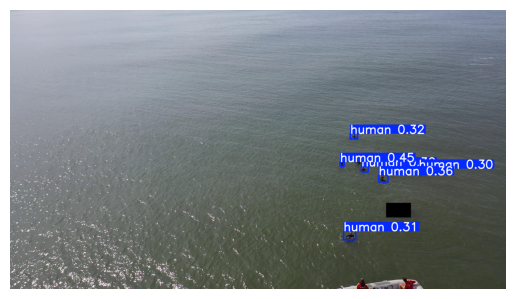

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 206 layers, 2,299,564 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 586.75it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


                   all        200       1072      0.622      0.488       0.49      0.154


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.4ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d172d5221d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [8]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)